# Mutational antigenic profiling of 2B06 antibody selection.

## Overview
The goal of this analysis notebook is to determine the comprehensive set of single amino-acid mutations in influenza A/WSN/33 hemagglutinin that allow for virus escape from the antibody D045-051310-2B06.
This antibody was provided by Patrick Wilson and previously characterized as a broadly cross-reactive HA [antibody](https://www.ncbi.nlm.nih.gov/pubmed/25689254). Deep mutational scanning experiments were performed by Lauren Gentles _in_ _vitro_. Selections were done using 50ug/mL of antibody and infections were performed on MDCK cells.

## Import Python packages

In [30]:
import os
import pandas
from IPython.display import display, HTML
import dms_tools2
from dms_tools2.ipython_utils import showPDF

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'no'

Using dms_tools2 version 2.4.10


## Process deep sequencing data

### Get information about samples
Here we define the samples by reading in a *.csv* file containing the selection type, library, percent infectivity, and R1 path. We then combind the selection type and the library to create the sample name.

In [63]:
samples = pandas.read_csv('data/samplelist.csv')
samples['name'] = samples.selection + '-' + samples.library

display(HTML(samples.to_html(index=False)))

fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)

selection,library,percent_infectivity,R1,name
2B06,Lib.1,0.17,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/1904...,2B06-Lib.1
Mock,Lib.1,,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/1904...,Mock-Lib.1
WSN-plasmid,,,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/1904...,WSN-plasmid-


### Run `dms2_batch_bcsubamp`

In [64]:
# file containing wildtype WSN HA sequence
refseq = './data/WSN-HA.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,285,36,37', 
                       '286,570,31,32',
                       '571,855,37,32',
                       '856,1140,31,36',
                       '1141,1425,29,33',
                       '1426,1698,40,43'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples[['name', 'R1']].to_html(index=False)))
samples[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 

print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,R1
2B06-Lib.1,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/1904...
Mock-Lib.1,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/1904...
WSN-plasmid-,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/1904...



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


### Look at summary plots
The *_readstats.pdf summary plot shows the number of reads that were retained or thrown away due to low quality barcodes. The black regions indicate reads that failed the Illumina filter.

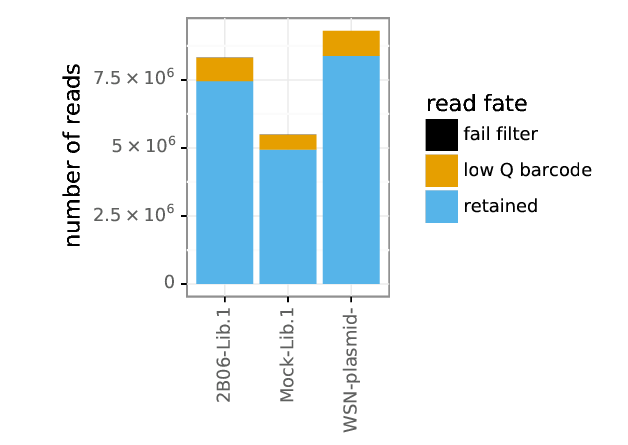

In [65]:
countsplotprefix = os.path.join(countsdir, 'summary')
showPDF(countsplotprefix + '_readstats.pdf', width=700)

The *_readsperbc.pdf summary plot shows the number of times each barcode was read for each sample.

The distributions for this analysis look good except for the mock sample which could use greater sequencing depth.

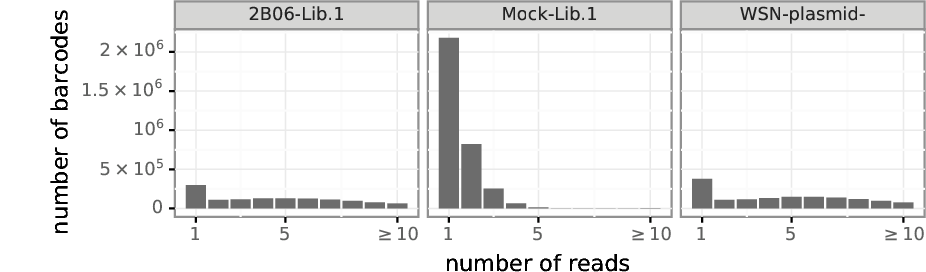

In [66]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The *_bcstats.pdf summary plot shows the number of barcodes that were able to be aligned to the reference WSN HA sequence. It will also show the number of barcodes that were not able to be alligned either because the barcode was not read enough times or the sequence just could not be aligned to the reference sequence.

You can see here that the mock sample that was not sequenced to a great enough depth has many barcodes thrown out due to too few reads.

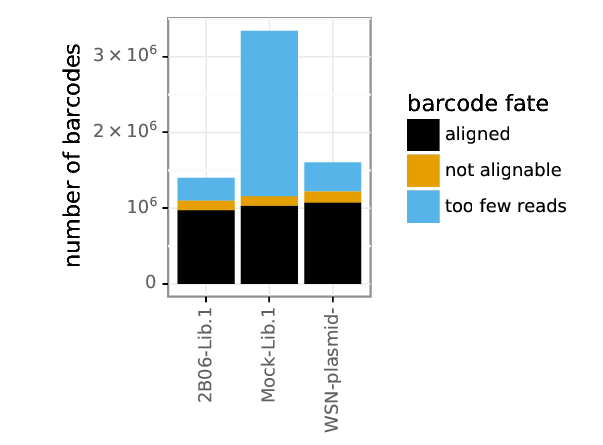

In [67]:
showPDF(countsplotprefix + '_bcstats.pdf', width=700)

The *_depth.pdf summary plot the depth (e.g. the number of reads for each codon) across the entire HA. This shows how well the barcodes were evenly represented between the different subamplicons.

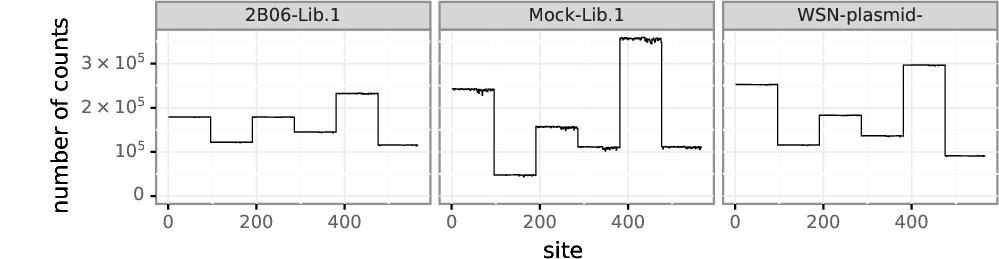

In [68]:
showPDF(countsplotprefix + '_depth.pdf')

The *_mutfreq.pdf summary plot shows the per codon frequency of mutations ar each site. In other words, it is the it is the cummulative number of mutations different from the reference sequence at each site.

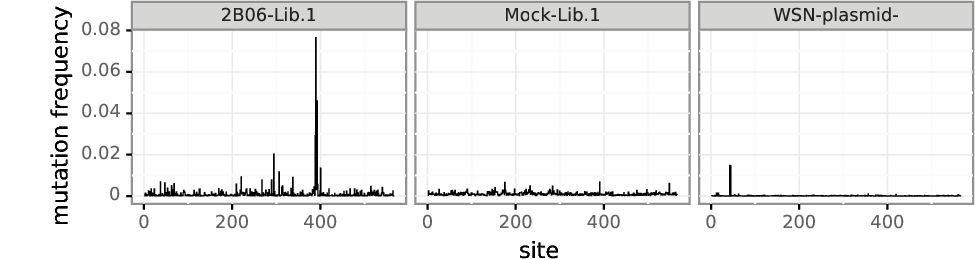

In [69]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The *_cumulmutcounts.pdf plot below shows the fraction fo mutations that are found less than or equal to the number of times indicated on the x-axis.

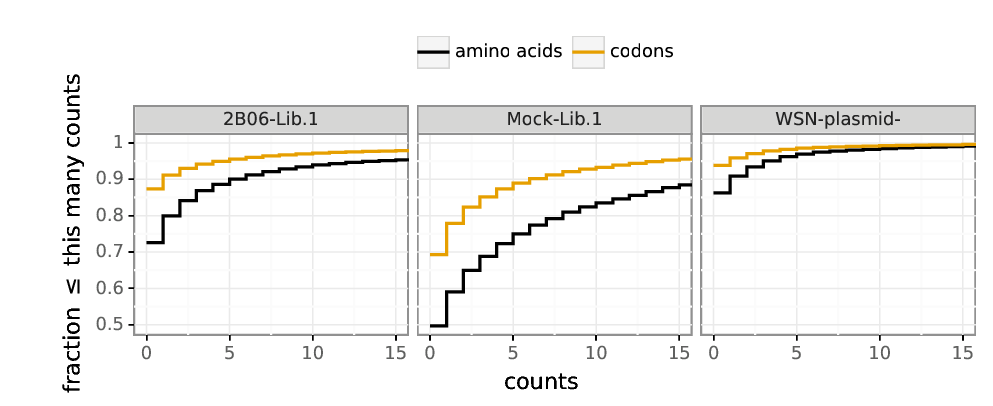

In [70]:
showPDF(countsplotprefix + '_cumulmutcounts.pdf')

The *_codonmuttypes.pdf summary plot the per-codon frequency of nonsynonymous, synonymous, and stop codon mutation across the entire gene.

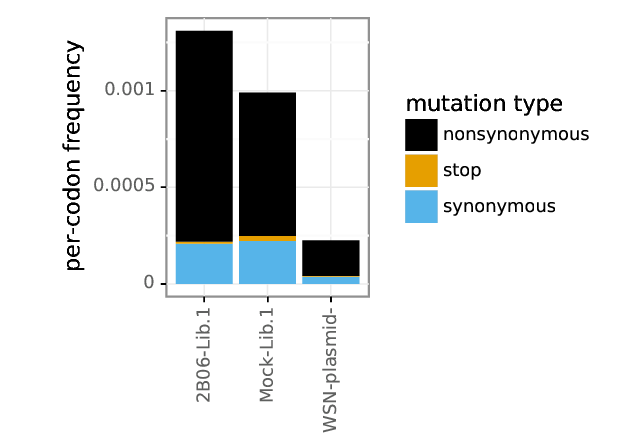

In [71]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=700)

The *_codonmuttypes.csv summary plot shows the nummerical values for the data above.

In [72]:
codonmuttypes = pandas.read_csv(countsplotprefix + '_codonmuttypes.csv').sort_index(axis=1)
display(HTML(codonmuttypes.to_html(index=False)))

name,nonsynonymous,stop,synonymous
2B06-Lib.1,0.001091,0.000010,0.000209
Mock-Lib.1,0.000741,0.000027,0.000223
WSN-plasmid-,0.000185,0.000004,0.000037


The *_codonntchanges.pdf summary plot shows the frequency of the number of nucleotide mutations that make up a given codon mutation (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

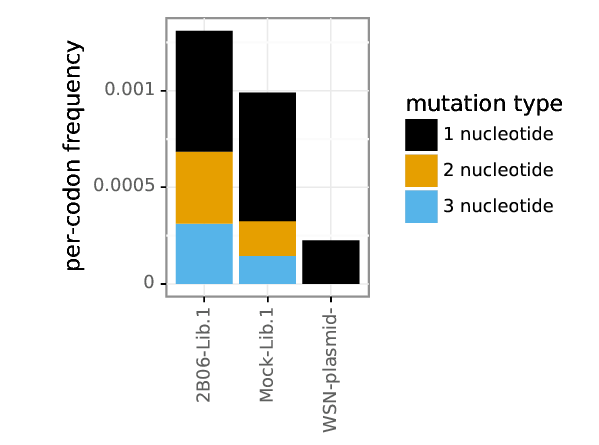

In [73]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=700)


The *_singlentchanges.pdf plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). For instance, in the case of influenza, when we get bad oxidative damage, then we see an excess of C to A mutations in the final cDNA since the damage is occurring to a ssRNA genome. If you are sequencing something without polarity, you might see both types of mutations

It seems like I am seeing oxidative damage in my lib 1 mock sample. This is not entirely suprising since I used older amplicons to generate this sample.

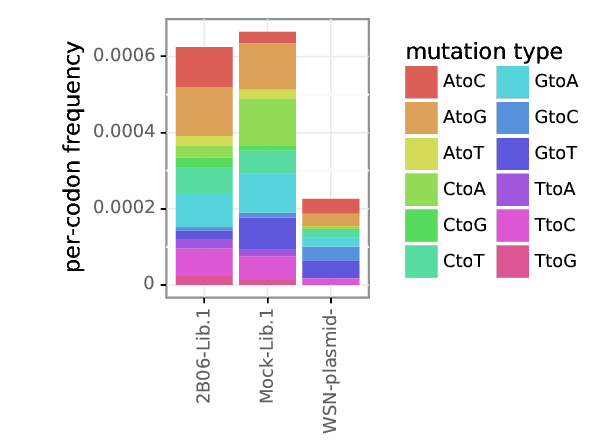

In [74]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=700)

## Compute differential selection
We first create a batch file to use with [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html). Note that we make the group arguments such that the samples taken from the same day with the same virus dose are compared with appropriate no antibody controls using the counts files generated above with [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html).

By grouping the replicates for the same antibody concentration and virus dose together in the batch file, we tell [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) to analyze these together and take their mean and median. Here I only have one technical and biological replicate. Once I have performed selection experiments with the two other libraries, this will be useful for determining the mean and median selection.

In [79]:
diffseldir = os.path.join(resultsdir, 'diffsel')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)

diffselbatchfile = os.path.join(diffseldir, 'batch.csv')
    
# create batch file for dms2_batch_diffsel
diffselbatch = pandas.DataFrame.from_records([
              # WSN library 1 selected with 50ug/mL of D045_051310_2B06
              ('2B06', '2B06-Lib.1', '2B06-Lib.1', 'Mock-Lib.1'),
             ],
             columns=['group', 'name', 'sel', 'mock']
             )
diffselbatch['err'] = 'WSN-plasmid-' # all samples have the same error control which is the plasmid in this case

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch.to_html(index=False)))

diffselbatch.to_csv(diffselbatchfile, index=False)

Here is the batch file that we write to CSV format to use as input:


group,name,sel,mock,err
2B06,2B06-Lib.1,2B06-Lib.1,Mock-Lib.1,WSN-plasmid-


Now we simply run [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html), getting the input counts from the directroy (--indir) where we placed the counts when we ran [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html).

In [80]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile} \
        --outdir {diffseldir} \
        --indir {countsdir} \
        --use_existing {use_existing}

Running this command creates a large number of output files giving the mutation and site [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) values in the formats of the mutdiffsel.csv and sitediffsel.csv files created by [dms2_diffsel](https://jbloomlab.github.io/dms_tools2/diffsel.html).

Specifically, there is a file for each individual sample, with a file name that gives the group and name specified for this sample in `--batchfile`.

In [81]:
!ls {diffseldir}/

2B06-2B06-50ug.log
2B06-2B06-Lib. 1.log
2B06-2B06-Lib.1.log
2B06-2B06-Lib.1_mutdiffsel.csv
2B06-2B06-Lib.1_sitediffsel.csv
2B06_diffsel.pdf
2B06.log
batch.csv
summary_2B06-absolutesitediffselcorr.pdf
summary_2B06-maxmutdiffselcorr.pdf
summary_2B06-meanmutdiffsel.csv
summary_2B06-meansitediffsel.csv
summary_2B06-medianmutdiffsel.csv
summary_2B06-mediansitediffsel.csv
summary_2B06-mutdiffselcorr.pdf
summary_2B06-positivesitediffselcorr.pdf
summary.log
summary_meanmaxdiffsel.pdf
summary_meanminmaxdiffsel.pdf
summary_meanpositivediffsel.pdf
summary_meantotaldiffsel.pdf
summary_medianmaxdiffsel.pdf
summary_medianminmaxdiffsel.pdf
summary_medianpositivediffsel.pdf
summary_mediantotaldiffsel.pdf


Now we are going to look at the correlation of samples within a given group. Again, this is not useful for the present data since I do not have replicate, but will be once I have done these.

Running [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) creates correlation plots for the mutation differential selection, positive site differential selection, absolute site differential selection, and maximum mutation differential selection for a site. These files have names like `summary_day-1-H17L19-25ug-6-mutdiffselcorr.pdf`. Below we show the plots for `mutdiffsel` and `positivesiteddiffsel` (plots are also made for `absolutesitediffsel` and `maxsitediffsel`, but are not shown below as they are less informative for this experiment).



mutdiffsel correlations:


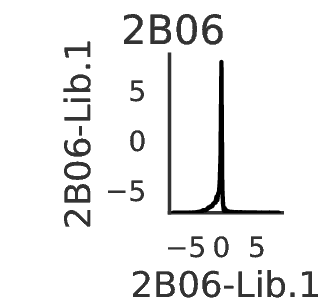


positivesitediffsel correlations:


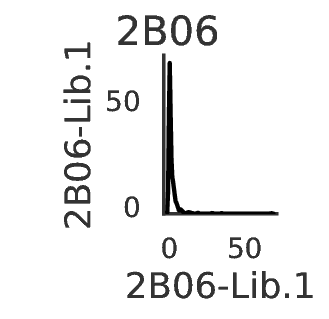

In [82]:
diffselprefix = os.path.join(diffseldir, 'summary_')
groups = diffselbatch['group'].unique()

for seltype in ['mutdiffsel', 'positivesitediffsel']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = diffselprefix + g + '-' + seltype + 'corr.pdf'
        plots.append(plot)
    showPDF(plots) 

Probably the most informative plot is simply the mean positive site differential selection. This plot show the total positive selection for all mutations combined at a give site as shown below.

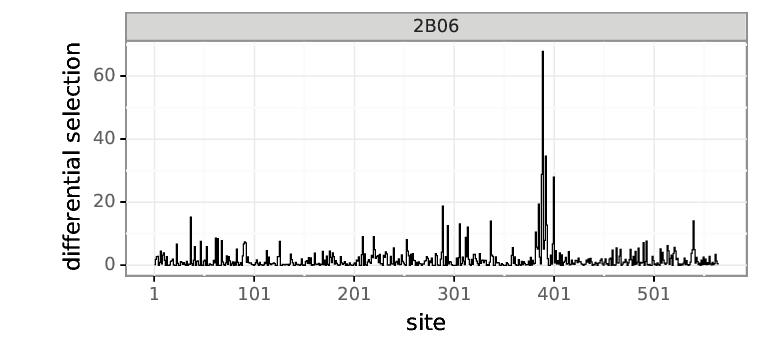

In [83]:
showPDF(diffselprefix + 'meanpositivediffsel.pdf', width=800)

## Logo plots of differential selection
The plots above summarize the site or maximum mutation differential selection using line plots. But the most comprehensive way to show this selection is in the form of logo plots that can be created with [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html).

We make those logog plots using the median mutation differential selection values returned by [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html). The reason that we plot the median rather than the mean is that we have noticed that is is often cleaner when there are >2 replicates.

We also add underlays of the wildtype sequence. To add the wildtype sequence, we can simply specify any file with the columns `wildtype` and `site --` any of our mutdiffsel files suffice. note that we add this using the -overlay1 option, and then convert it to an underlay with `--underlay yes` since underlays look better than overlays here.


Creating logo plot for 2B06 from ./results/diffsel/summary_2B06-medianmutdiffsel.csv


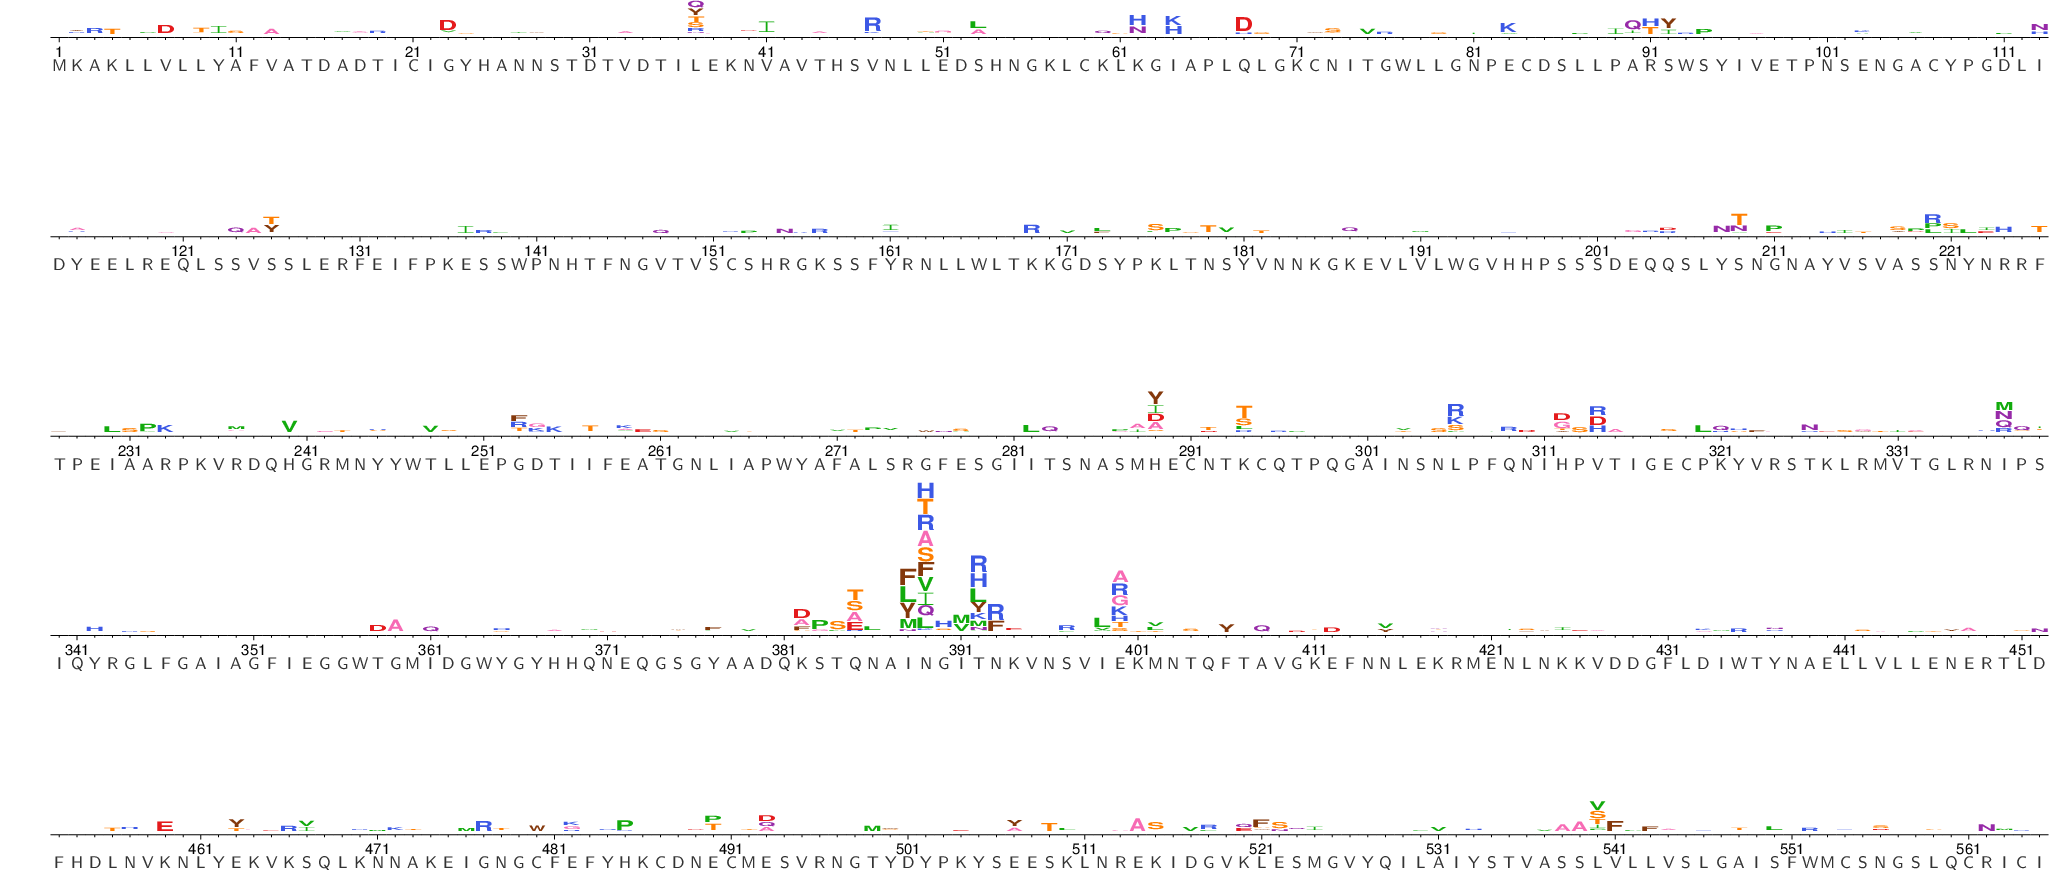

In [84]:
groups = diffselbatch['group'].unique()
for group in groups:
    mutdiffsel = diffselprefix + group + '-medianmutdiffsel.csv'

    logoplot = os.path.join(diffseldir, '{0}_diffsel.pdf'.format(group))
    print("\nCreating logo plot for {0} from {1}".format(group, mutdiffsel))
    
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {group} \
            --outdir {diffseldir} \
            --restrictdiffsel positive \
            --sepline no \
            --nperline 113 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)